In [1]:
import numpy as np
import scipy as sp
from importlib import reload
import neuraltda.topology2 as tp2
import glob
import os
import pickle
import matplotlib.pyplot as plt
import h5py as h5
%matplotlib inline

import seaborn as sns
import pandas as pd
from neuraltda import TPLCP
from neuraltda import FRLCP
reload(TPLCP)

import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/DailyLog/20170912/


/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
block_path = '/home/brad/krista/B1075/P01S03/'
block_path = '/home/brad/krista/B1083/P03S03/'
bdf = glob.glob('/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-fulltrial/20170626T223014Z-10.0-5.0.binned')[0]

birds = ['B1083', 'B1075', 'B1235', 'B1056']
#birds = ['B1075']

bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

# Stim classes
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_scaled_burung': 'R', 'F_scaled_burung':'L', 'G_scaled_burung':'R', 'H_scaled_burung':'L'}
B1056_classes = {'A_scaled_burung': 'R', 'B_scaled_burung':'L', 'C_scaled_burung':'R', 'D_scaled_burung':'L'}

stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1083_stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1075_stims = ['E_40k', 'F_40k', 'G_40k', 'H_40k']
B1235_stims = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
B1056_stims = ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung']

stim_classes = {'B1083': B1083_classes, 'B1075': B1075_classes,
                'B1235': B1235_classes, 'B1056': B1056_classes}
bird_stims = {'B1083': B1083_stims, 'B1075': B1075_stims,
              'B1235': B1235_stims, 'B1056': B1056_stims}

In [3]:
winsize = 10.0
dtovr = winsize*0.5
comment = 'ForLogisticPred'
segment_info = [0,0]

bdfs = []
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs.append([bird, bdf])

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170724T191746Z-10.0-5.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170724T194237Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170724T194243Z-10.0-5.0.binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170825T212326Z-10.0-5.0.binned


In [4]:

# parameters
reload(tp2)
analysis_id = 'test2'
thresh = 4.0
nperms = 20

ncellsperm = 30
dims = [0,1,2,3,4]
Ntimes = 10
twin = np.linspace(0, 6000, Ntimes)
p_test = 0.2
N_tests = 60

In [5]:
# Behavioral class decoder accuracy vs shuffled. 
name = 'ShuffleClassLabels'
acframe_behavioralclass = pd.DataFrame(columns=['Bird', 'Accuracy', 'Shuffle'])
for b in bdfs:
    bird = b[0]
    bdf = b[1]
    stimc = stim_classes[bird]
    stims = bird_stims[bird]
    (bcAll, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr)

    accuracies = TPLCP.predict_stimuli_classes(bcAll, Ntimes, stims, stimc, p_test, N_tests)
    accuracies_shuff = TPLCP.predict_stimuli_classes(bcAll, Ntimes, stims, stimc, p_test, N_tests, shuff_Y=True)
    acframeapp = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies, 'Shuffle': N_tests*['No'] })
    acframeapps = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies_shuff, 'Shuffle': N_tests*['Yes'] })
    acframe_behavioralclass = acframe_behavioralclass.append(acframeapp)
    acframe_behavioralclass = acframe_behavioralclass.append(acframeapps)

    

total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts:

total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts:

In [6]:
with open(os.path.join(figsavepth, 'acframe_behavioralclass.pkl'), 'wb') as f:
    pickle.dump(acframe_behavioralclass, f)

/home/brad/DailyLog/20170911/10.0-5.0-4.0-20-30-10-0.2-60-ShuffleClassLabels-stripplot.eps


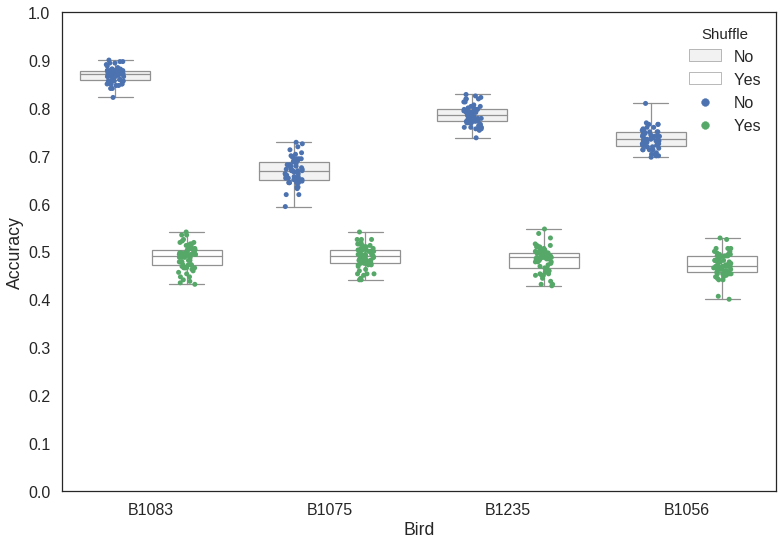

In [13]:
#stripplot
name = 'ShuffleClassLabels-stripplot'
sns.set_context('poster')
sns.set_style('white')
plt.figure()
sns.stripplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_behavioralclass,
              jitter=True, split=True)
sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_behavioralclass, color='white',
            linewidth=1.25, whis=100)
plt.plot()

plt.yticks([x/10 for x in range(11)])
#plt.ylim([0.3, 1])
figpath = os.path.join(figsavepth, '{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))
print(figpath)
plt.savefig(figpath)

In [ ]:

sns.set_context('poster')
sns.set_style('white')
plt.figure()
sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_behavioralclass)
plt.plot()
plt.ylim([0, 1])
plt.yticks([x/10 for x in range(11)])

figpath = os.path.join(figsavepth, '{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))
print(figpath)
plt.savefig(figpath)

In [7]:
# Decode stimulus name

# Stim classes
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_scaled_burung': 'R', 'F_scaled_burung':'L', 'G_scaled_burung':'R', 'H_scaled_burung':'L'}

stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1083_stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1075_stims = ['E_40k', 'F_40k', 'G_40k', 'H_40k']
B1235_stims = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']

stim_classes = {'B1083': B1083_classes, 'B1075': B1075_classes, 'B1235': B1235_classes}
bird_stims = {'B1083': B1083_stims, 'B1075': B1075_stims, 'B1235': B1235_stims}



# Stim classes
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_scaled_burung': 'R', 'F_scaled_burung':'L', 'G_scaled_burung':'R', 'H_scaled_burung':'L'}
B1056_classes = {'A_scaled_burung': 'R', 'B_scaled_burung':'L', 'C_scaled_burung':'R', 'D_scaled_burung':'L'}

stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1083_stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1075_stims = ['E_40k', 'F_40k', 'G_40k', 'H_40k']
B1235_stims = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
B1056_stims = ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung']

stim_classes = {'B1083': B1083_classes, 'B1075': B1075_classes,
                'B1235': B1235_classes, 'B1056': B1056_classes}
bird_stims = {'B1083': B1083_stims, 'B1075': B1075_stims,
              'B1235': B1235_stims, 'B1056': B1056_stims}

name = 'PredictStimulusID'
acframe_stimulusID = pd.DataFrame(columns=['Bird', 'Accuracy', 'Shuffle'])
for b in bdfs:
    bird = b[0]
    bdf = b[1]
    print(bird)
    #stimc = stim_classes[bird]
    #stims = bird_stims[bird]
    (bcAll, t, t_ms) =tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr)
    print('Completed Betti Computation...')

    stims = bcAll.keys()
    stimc = {x: x for x in stims}
    accuracies = TPLCP.predict_stimuli_classes(bcAll, Ntimes, stims, stimc, p_test, N_tests)
    accuracies_shuff = TPLCP.predict_stimuli_classes(bcAll, Ntimes, stims, stimc, p_test, N_tests, shuff_Y=True)
    acframeapp = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies, 'Shuffle': N_tests*['No'] })
    acframeapps = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies_shuff, 'Shuffle': N_tests*['Yes'] })
    acframe_stimulusID = acframe_stimulusID.append(acframeapp)
    acframe_stimulusID = acframe_stimulusID.append(acframeapps)

B1083
Completed Betti Computation...
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
total pts: 3200, ntrain: 2560
tot

total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts: 6400, ntrain: 5120
total pts:

In [9]:
with open(os.path.join(figsavepth, 'acframe_stimulusID.pkl'), 'wb') as f:
    pickle.dump(acframe_stimulusID, f)

/home/brad/DailyLog/20170911/10.0-5.0-4.0-20-30-10-0.2-60-PredictStimID-stripplot.eps


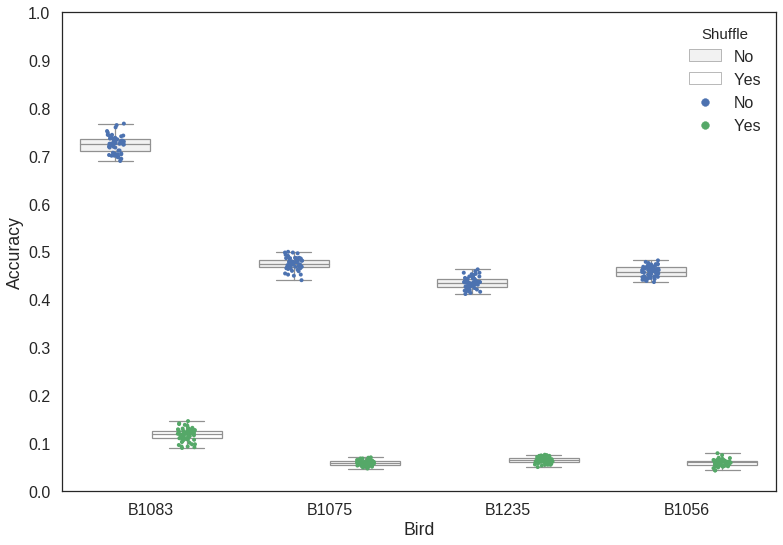

In [20]:
#stripplot
name = 'PredictStimID-stripplot'
sns.set_context('poster')
sns.set_style('white')
plt.figure()
sns.stripplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_stimulusID,
              jitter=True, split=True, size=4)
sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_stimulusID, color='white',
            linewidth=1.25, whis=100)
plt.plot()

plt.yticks([x/10 for x in range(11)])
#plt.ylim([0.3, 1])

figpath = os.path.join(figsavepth, '{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))
print(figpath)
plt.savefig(figpath)

In [ ]:
sns.set_context('poster')
sns.set_style('white')
plt.figure()

sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_stimulusID)
plt.ylim([0, 1])
plt.yticks([x/10 for x in range(11)])

figpath = os.path.join(figsavepth, '{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))
print(figpath)
plt.savefig(figpath)

In [10]:
# Decode arbitrary unfamiliar stimuli
reload(TPLCP)
# Stim classes
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_scaled_burung': 'R', 'F_scaled_burung':'L', 'G_scaled_burung':'R', 'H_scaled_burung':'L'}


B1083_unf_stims = ['I_40k', 'J_40k', 'K_40k', 'L_40k']

B1075_unf_stims = ['A_40k', 'B_40k', 'C_40k', 'D_40k',
                   'I_40k', 'J_40k', 'K_40k', 'L_40k',
                   'M_40k', 'N_40k', 'O_40k', 'P_40k']

B1235_unf_stims = ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung',
                   'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung',
                   'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung',]

B1056_unf_stims = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung',
                   'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung',
                   'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung',]

stimclab = ['R', 'L']
bird_unf_stims = {'B1083': B1083_unf_stims, 'B1075': B1075_unf_stims,
                  'B1235': B1235_unf_stims, 'B1056': B1056_unf_stims}


name = 'PredictArbitraryUnfamiliar'
acframe_arbunf = pd.DataFrame(columns=['Bird', 'Accuracy', 'Shuffle'])
for b in bdfs:
    bird = b[0]
    bdf = b[1]
    print(bird)
    #stimc = stim_classes[bird]
    stims = bird_unf_stims[bird]
    (bcAll, t, t_ms) =tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr)
    print('Completed Betti Computation...')

    #bc2s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 2, twin, winsize, dtovr, shuffle=True)
    #bc1s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 1, twin, winsize, dtovr, shuffle=True)
    #bc0s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 0, twin, winsize, dtovr, shuffle=True)
    #bc3s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 3, twin, winsize, dtovr, shuffle=True)
    
    
    #stims = bcAll.keys()
    
    accuracies = TPLCP.predict_arbitrary_classes(bcAll, stims, stimclab, p_test, N_tests)
    accuracies_shuff = TPLCP.predict_arbitrary_classes(bcAll, stims, stimclab, p_test, N_tests, shuff_Y=True)
    acframeapp = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies, 'Shuffle': N_tests*['No'] })
    acframeapps = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies_shuff, 'Shuffle': N_tests*['Yes'] })
    acframe_arbunf = acframe_arbunf.append(acframeapp)
    acframe_arbunf = acframe_arbunf.append(acframeapps)
    
with open(os.path.join(figsavepth, 'acframe_arbunf.pkl'), 'wb') as f:
    pickle.dump(acframe_arbunf, f)

B1083
Completed Betti Computation...
['I_40k', 'J_40k', 'K_40k', 'L_40k']
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1

total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts: 4800, ntrain: 3840
total pts:

/home/brad/DailyLog/20170911/10.0-5.0-4.0-20-30-10-0.2-60-PredictArbitraryUnfamiliar.eps


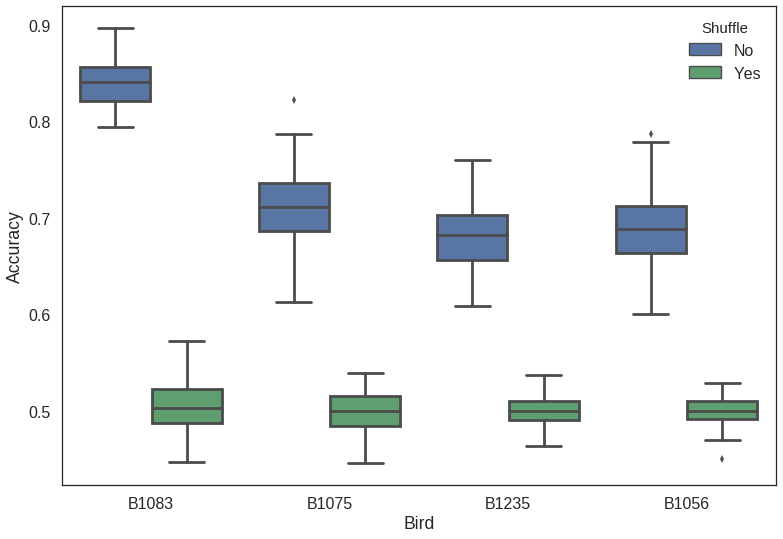

In [22]:
 
plt.figure()
sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_arbunf)
#plt.savefig('/home/brad/DailyLog/20170831/{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))

figpath = os.path.join(figsavepth, '{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))
print(figpath)
plt.savefig(figpath)

/home/brad/DailyLog/20170912/10.0-5.0-4.0-20-30-10-0.2-60-FamilarvsUnfamiliar.eps


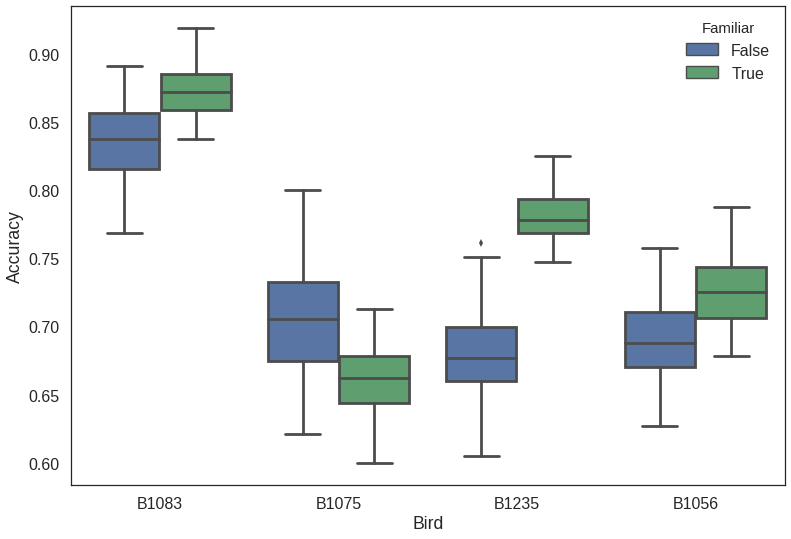

In [8]:
# plot familiar vs. unfamiliar
acframe_arbunf['Familiar'] = len(acframe_arbunf)*[False]
acframe_behavioralclass['Familiar'] = len(acframe_behavioralclass)*[True]

acframe_fam_unf = acframe_arbunf.append(acframe_behavioralclass)

name = 'FamilarvsUnfamiliar'
sns.boxplot(x='Bird', y='Accuracy', hue='Familiar', data=acframe_fam_unf[acframe_fam_unf['Shuffle']=='No'])
#plt.savefig('/home/brad/DailyLog/20170831/{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))

figpath = os.path.join(figsavepth, '{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))
print(figpath)
plt.savefig(figpath)

/home/brad/DailyLog/20170912/10.0-5.0-4.0-20-30-10-0.2-60-UnfvFam-stripplot.eps


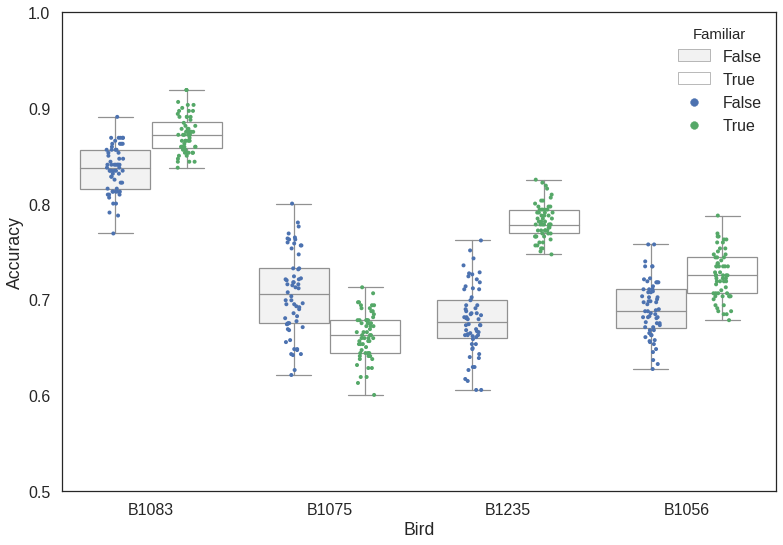

In [9]:
#stripplot
name = 'UnfvFam-stripplot'
sns.set_context('poster')
sns.set_style('white')
plt.figure()
sns.stripplot(x='Bird', y='Accuracy', hue='Familiar', data=acframe_fam_unf[acframe_fam_unf['Shuffle']=='No'],
              jitter=True, split=True, size=4)
sns.boxplot(x='Bird', y='Accuracy', hue='Familiar', data=acframe_fam_unf[acframe_fam_unf['Shuffle']=='No'], color='white',
            linewidth=1.25, whis=100)
plt.ylim([0.5, 1.0])
plt.plot()

#plt.yticks([x/10 for x in range(11)])
#plt.ylim([0.3, 1])
#plt.savefig('/home/brad/DailyLog/20170831/{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))

figpath = os.path.join(figsavepth, '{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))
print(figpath)
plt.savefig(figpath)

In [ ]:
from scipy.stats import ttest_ind
ufu = acframe_fam_unf[acframe_fam_unf['Shuffle']=='No']
print(ufu.head())
b = 'B1075'
fam = ufu[(ufu['Bird'] == b) & (ufu['Familiar']==True)]
unf = ufu[(ufu['Bird'] == b) & (ufu['Familiar']==False)]

ttest_ind(fam['Accuracy'], unf['Accuracy'], equal_var=False)

In [ ]:
test1 = ufu['Bird'] == b
test2 = ufu['Familiar'] == True

# Firing rate comparisons

In [10]:
reload(FRLCP)
name = 'FiringRate'
acframe_FR = pd.DataFrame(columns=['Bird', 'Accuracy', 'Shuffle', 'Type'])
for b in bdfs:
    bird = b[0]
    bdf = b[1]
    print(bird)
    poptensors = {}
    with h5.File(bdf, 'r') as f:
        for stim in list(f.keys()):
            poptensors[stim] = tp2.build_permuted_data_tensor(np.array(f[stim]['pop_tens']), ncellsperm, nperms)
    stims = bird_stims[bird]
    stimc = stim_classes[bird]
    accuracies = FRLCP.predict_stimuli_classes_population_FR(poptensors, Ntimes, stims, stimc, p_test, N_tests)
    accuracies_shuff = FRLCP.predict_stimuli_classes_population_FR(poptensors, Ntimes, stims, stimc, p_test, N_tests, shuff_Y=True)
    acframeapp = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies, 'Shuffle': N_tests*['No'], 'Type': N_tests*['FR']})
    acframeapps = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies_shuff, 'Shuffle': N_tests*['Yes'], 'Type': N_tests*['FR']})
    acframe_FR = acframe_FR.append(acframeapp)
    acframe_FR = acframe_FR.append(acframeapps)




B1083
20
(30, 1200, 400)
(30, 1200, 400)
(30, 1200, 400)
(30, 1200, 400)
1600
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrai

total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
20
(30, 1325, 400)
(30, 1325, 400)
(30, 1325, 400)
(30, 1325, 400)
1600
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 1280
total pts: 1600, ntrain: 128

/home/brad/DailyLog/20170912/10.0-5.0-4.0-20-30-10-0.2-60-FiringRate.eps


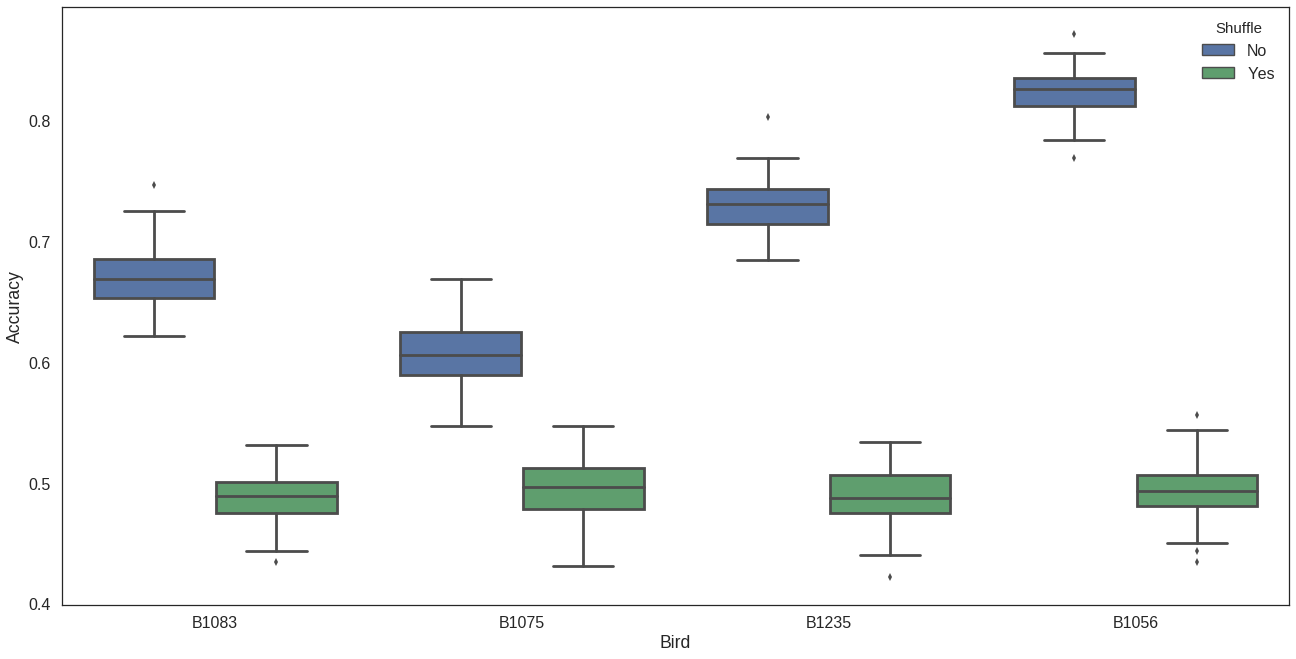

In [11]:
 
plt.figure(figsize=(22,11))
sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_FR)
#plt.savefig('/home/brad/DailyLog/20170831/FRpredict2_{}_{}_{}_{}.eps'.format(Ntimes, p_test, N_tests, name))

figpath = os.path.join(figsavepth, '{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))
print(figpath)
plt.savefig(figpath)

In [12]:
acframe_FRTop = acframe_fam_unf[(acframe_fam_unf['Familiar']==True) & (acframe_fam_unf['Shuffle'] == 'No')]
acframe_FRTop['Type'] = pd.Series(len(acframe_FRTop)*['Top'], index=acframe_FRTop.index)
acframe_FRTop = acframe_FRTop.append(acframe_FR[acframe_FR['Shuffle'] == 'No'])

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
acframe_FRTop

In [ ]:
plt.figure(figsize=(22,11))
sns.boxplot(x='Bird', y='Accuracy', hue='Type', data=acframe_FRTop)
#plt.savefig('/home/brad/DailyLog/20170831/FRpredictVsTopology_{}_{}_{}_{}.eps'.format(Ntimes, p_test, N_tests, name))

figpath = os.path.join(figsavepth, 'FRpredictVsTopology_{}_{}_{}_{}.eps'.format(Ntimes, p_test, N_tests, name))
print(figpath)
plt.savefig(figpath)

/home/brad/DailyLog/20170912/10.0-5.0-4.0-20-30-10-0.2-60-FRvsTop-stripplot.eps


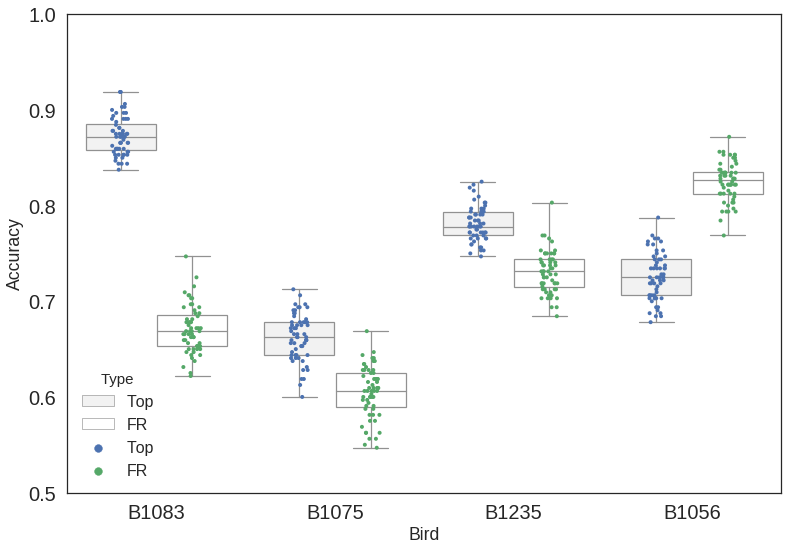

In [15]:
#stripplot
name = 'FRvsTop-stripplot'
sns.set_context('poster')
sns.set_style('white')
plt.figure()
sns.stripplot(x='Bird', y='Accuracy', hue='Type', data=acframe_FRTop,
              jitter=True, split=True, size=4)
sns.boxplot(x='Bird', y='Accuracy', hue='Type', data=acframe_FRTop, color='white',
            linewidth=1.25, whis=100)
plt.ylim([0.5, 1.0])
plt.plot()
ax = plt.gca()
ax.tick_params(labelsize=20)

#plt.yticks([x/10 for x in range(11)])
#plt.ylim([0.3, 1])
#plt.savefig('/home/brad/DailyLog/20170831/{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))

figpath = os.path.join(figsavepth, '{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))
print(figpath)
plt.savefig(figpath, bbox_inches='tight')

In [ ]:
acframe_FR

In [ ]:
from sklearn.linear_model import LogisticRegression
# Testing FR predict 
pop_tensors = poptensors
dimensionality=Ntimes
stimuli = stims
pc_test = p_test
n_predict = N_tests
shuff_Y = False
(ncells, nwin, ntrials) = pop_tensors[stimuli[0]].shape
wins = [int(round(x)) for x in np.linspace(0, nwin-1, dimensionality)]
pred_y = np.array([])
pred_x = np.empty((0, dimensionality))

for stim in stimuli:
    dat = np.mean(pop_tensors[stim], axis=0)
    dat = dat[wins, :].T
    stim_vec = np.array(ntrials*[stimc[stim]])
    pred_y = np.hstack([pred_y,stim_vec])
    pred_x = np.vstack([pred_x, dat])

pred_Y = np.array(pred_y)
pred_X = np.array(pred_x)

if shuff_Y:
    pred_Y = np.random.permutation(pred_Y)
accuracies = []
for pred in range(n_predict):
    total_pts = len(pred_Y)
    ntrain = int(np.round((1-pc_test)*total_pts))
    L = LogisticRegression()
    inds = np.random.permutation(np.arange(len(pred_Y)))
    inds_train = inds[0:ntrain]
    inds_predict = inds[ntrain:]
    L.fit(pred_X[inds_train, :], pred_Y[inds_train])
    test = L.predict(pred_X[inds_predict, :])
    acc = [test[x] == pred_Y[inds_predict][x] for x in range(len(inds_predict))]
    accuracy = np.sum(acc) / len(inds_predict)
    accuracies.append(accuracy);
    


In [ ]:
len(inds_predict)

In [ ]:
len(inds_train)

In [ ]:
pred_y.shape

In [ ]:
acc =acframe_behavioralclass['Accuracy']

In [ ]:
np.array(acc)*16